In [1]:
import osmnx as ox
import pandas as pd
import pvlib 
from pvlib import solarposition
import datetime 

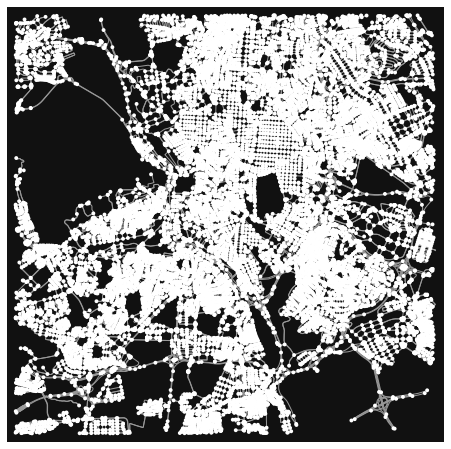

In [2]:
superf = {'surface_tilt': 30,'surface_azimuth': 180} #Inclinación y acimut de la superficie inclinada
coord_origen = (40.405551, -3.700684 ) #ETSIDI
coord_destino = (40.408800, -3.701271 )#Plaza Lavapiés
mapa_nodos = ox.graph_from_point (coord_origen, dist=7000, dist_type ='bbox' , network_type = 'drive')
fig, ax = ox.plot_graph(mapa_nodos) 
ox.speed.add_edge_speeds(mapa_nodos , hwy_speeds = 50 , fallback = None , precision = 1 )
ox.speed.add_edge_travel_times( mapa_nodos , precision = 1 )

In [3]:
#---------------------NODOS ORIGEN Y DESTINO SEGÚN COORDENADAS----------------------------------#
nodo_origen = ox.get_nearest_node(mapa_nodos, coord_origen, method='haversine', return_dist=False)
nodo_destino = ox.get_nearest_node(mapa_nodos, coord_destino, method='haversine', return_dist=False)
nodo_origen,nodo_destino

(26494692, 21941619)

In [4]:
#GRAFICAR A GEODATAFRAME
nodos, caminos = ox.graph_to_gdfs(mapa_nodos) #Función de OSMnx que convierte el multidigraph en geodataframes de NODOS y LÍNEAS
pd.set_option("max_columns", None) #Showing only two columns
pd.set_option("max_rows", None)
nodos.head() #GeoDataFrames de los nodos

,y,x,highway,street_count,ref,geometry
osmid,,,,,,
171946,40.421264,-3.684452,traffic_signals,3,NaN,POINT (-3.68445 40.42126)
171951,40.417360,-3.688989,NaN,4,NaN,POINT (-3.68899 40.41736)
171952,40.414991,-3.688980,NaN,3,NaN,POINT (-3.68898 40.41499)
171953,40.412775,-3.688901,NaN,4,NaN,POINT (-3.68890 40.41277)
171954,40.409469,-3.688799,NaN,3,NaN,POINT (-3.68880 40.40947)


In [5]:
caminos.head()

osmid  oneway lanes                  name  \
u      v          key                                                  
171946 26513145   0    807334397    True     4    Calle de Velázquez   
171951 1209331009 0    104864843    True   NaN    Calle Juan de Mena   
       26486636   0    553113575    True     3  Calle de Alfonso XII   
171952 26486617   0    317302445    True     3  Calle de Alfonso XII   
171953 2681222064 0     28401583    True   NaN        Calle Espalter   

                           highway maxspeed  length  speed_kph  travel_time  \
u      v          key                                                         
171946 26513145   0       tertiary       50  41.093       50.0          3.0   
171951 1209331009 0    residential      NaN  18.733       45.1          1.5   
       26486636   0       tertiary       50  81.552       50.0          5.9   
171952 26486617   0       tertiary      NaN  26.251       47.5          2.0   
171953 2681222064 0    residential      NaN  18.835       45.1          1.5   

                                                                geometry  \
u      v          key                                                      
171946 26513145   0    LINESTRING (-3.68445 40.42126, -3.68442 40.42163)   
171951 1209331009 0    LINESTRING (-3.68899 40.41736, -3.68885 40.41749)   
       26486636   0    LINESTRING (-3.68899 40.41736, -3.68903 40.416...   
171952 26486617   0    LINESTRING (-3.68898 40.41499, -3.68897 40.41475)   
171953 2681222064 0    LINESTRING (-3.68890 40.41277, -3.68876 40.41290)   

                      access  ref bridge tunnel junction width est_width  \
u      v          key                                                      
171946 26513145   0      NaN  NaN    NaN    NaN      NaN   NaN       NaN   
171951 1209331009 0      NaN  NaN    NaN    NaN      NaN   NaN       NaN   
       26486636   0      NaN  NaN    NaN    NaN      NaN   NaN       NaN   
171952 26486617   0      NaN  NaN    NaN    NaN      NaN   NaN       NaN   
171953 2681222064 0      NaN  NaN    NaN    NaN      NaN   NaN       NaN   

                      landuse  
u      v          key          
171946 26513145   0       NaN  
171951 1209331009 0       NaN  
       26486636   0       NaN  
171952 26486617   0       NaN  
171953 2681222064 0       NaN

In [6]:
#--------------------------NODOS DE LA RUTA---------------------------------------#
ruta = ox.shortest_path(G=mapa_nodos, orig=nodo_origen, dest=nodo_destino, weight='length')
print(ruta) #Obtenemos la lista de nodos que se encuentran en el camino más corto.
len(ruta)

[26494692, 26494693, 26494655, 26494649, 26493405, 21759574, 21941563, 3190460047, 21941587, 21941619]


10

In [7]:
#--------------------------INFORMACIÓN CALLES DE LA RUTA ---------------------------------------#
lista_caminos =[]
for x in range(1,len(ruta)):
    lista_caminos.append(mapa_nodos[ruta[x-1]][ruta[x]])
len(lista_caminos)

9

In [8]:
#--------------------------NOMBRE DE LAS CALLES---------------------------------------#
nombre_calles =[]
for x in range(0,len(lista_caminos)):
    nombre_calles.append(lista_caminos[x][0]['name'])
len(nombre_calles)

9

In [9]:
#--------------------------NODOS INICIALES DE LAS CALLES---------------------------------------#
nodo1_calle =[]
for x in range(0,len(ruta)-1):
    nodo1_calle.append(ruta[x])
len(nodo1_calle)

9

In [10]:
#--------------------------NODOS FINALES DE LAS CALLES---------------------------------------#
nodo2_calle =[]
for x in range(1,len(ruta)):
    nodo2_calle.append(ruta[x])
len(nodo2_calle)

9

In [11]:
#--------------------------COORDENADAS TOTALES EN UNA LISTA---------------------------------------#
lista_coords_nodos =[]
for x in range(0,len(ruta)):
    lista_coords_nodos.append(mapa_nodos.nodes[ruta[x]]['y'])
    lista_coords_nodos.append(mapa_nodos.nodes[ruta[x]]['x'])
len(lista_coords_nodos)

20

In [12]:
#--------------------------COORDENADAS FINALES DE LA RUTA---------------------------------------#
coords_nodos = []
for i in range(0, len(lista_coords_nodos), 2):
    coords_nodos.append(lista_coords_nodos[i:i+2])
len(coords_nodos)

10

In [13]:
#--------------------------COORDENADAS INICIALES DE LAS CALLES---------------------------------------#
coords1_calle =[]
for x in range(0,len(ruta)-1): #Elimino la ultima coordenada para tener longitud 30
    coords1_calle.append(coords_nodos[x])
len(coords1_calle) 

9

In [14]:
#-------------------------COORDENADAS FINALES DE LAS CALLES--------------------------------------#
coords2_calle =[]
for x in range(1,len(ruta)):
    coords2_calle.append(coords_nodos[x])
len(coords2_calle)

9

<Figure size 432x288 with 0 Axes>

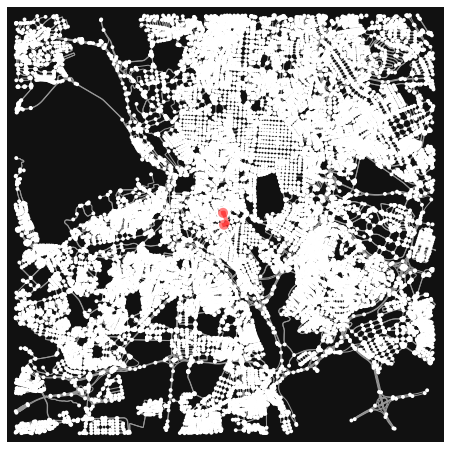

In [15]:
#----------------------------TRAZADO DE LA RUTA-------------------------------------------#
caminos.plot(ax=ax, linewidth=1, edgecolor='dimgray') #Líneas
fig2, ax = ox.plot_graph_route(mapa_nodos, ruta)

In [16]:
#-------------------------INFORMACIÓN POR NODO DE LA RUTA----------------------------------------#
ruta_info=ox.utils_graph.get_route_edge_attributes(mapa_nodos, ruta, attribute=None, minimize_key='length', retrieve_default=None)
ruta_info

[{'osmid': 4350218,
  'oneway': True,
  'lanes': '2',
  'name': 'Ronda de Valencia',
  'highway': 'primary',
  'maxspeed': '50',
  'length': 142.701,
  'geometry': <shapely.geometry.linestring.LineString at 0x143684a43a0>,
  'speed_kph': 50.0,
  'travel_time': 10.3},
 {'osmid': 16560347,
  'oneway': True,
  'lanes': '1',
  'name': 'Calle Fray Luis de León',
  'highway': 'residential',
  'maxspeed': '30',
  'length': 8.085,
  'speed_kph': 30.0,
  'travel_time': 1.0},
 {'osmid': 7972743,
  'oneway': True,
  'lanes': '1',
  'name': 'Calle de Valencia',
  'highway': 'residential',
  'length': 112.324,
  'geometry': <shapely.geometry.linestring.LineString at 0x1436848fcd0>,
  'speed_kph': 45.1,
  'travel_time': 9.0},
 {'osmid': 7972743,
  'oneway': True,
  'lanes': '1',
  'name': 'Calle de Valencia',
  'highway': 'residential',
  'length': 63.571,
  'geometry': <shapely.geometry.linestring.LineString at 0x1436848faf0>,
  'speed_kph': 45.1,
  'travel_time': 5.1},
 {'osmid': 7972743,
  'onewa

In [17]:
#----------------------------VELOCIDAD POR CALLE EN KPH-------------------------------------------#
calles_speed =[]
for x in range(0,len(ruta_info)):
    calles_speed.append(ruta_info[x]['speed_kph'])
len(calles_speed)

9

In [18]:
#----------------------------TIEMPO POR CALLE EN SEGS-------------------------------------------#
calles_tiempo =[]
for x in range(0,len(ruta_info)):
   calles_tiempo.append(ruta_info[x]['travel_time'])
len(calles_tiempo)

9

In [19]:
#----------------------------HORAS INTERMEDIAS DE LA RUTA-------------------------------------------#
from datetime import datetime, date, time, timedelta
from datetime import date
from datetime import datetime
hora_salida = datetime(2016, 7, 28, 14, 30, 00) #y, m, d, h, min, s    
horas_intermedias = hora_salida
horas_trayecto = []
for x in range(0,len(ruta_info)):
   horas_trayecto.append(horas_intermedias + timedelta(seconds=ruta_info[x]['travel_time']))
   horas_intermedias += timedelta(seconds=ruta_info[x]['travel_time'])

In [20]:
list_ruta =[]
for x in range(0,len(ruta)):
    list_ruta.append(ruta[x])
    
list_ruta


[26494692,
 26494693,
 26494655,
 26494649,
 26493405,
 21759574,
 21941563,
 3190460047,
 21941587,
 21941619]

In [21]:
import datetime   

In [22]:
medidas_tmy = []
datos=[]
datos_2016=[]
horario_ruta=[]
for x in range(0,len(list_ruta)):
    medidas_tmy.append (pvlib.iotools.get_pvgis_tmy(coords_nodos[x][0], coords_nodos[x][1], outputformat='epw', 
    url='https://re.jrc.ec.europa.eu/api/',startyear=2005, endyear=2016, timeout=30))
    #Se añade al vector medida cada situación de cada longitud y latitud
    datos.append(medidas_tmy[x][0][["ghi","dni","dhi"]])
    #Bien
    nueva_fecha=[]
    for i in range(len(datos[x])): 
         nueva_fecha.append(datos[x].index[i].replace(year=2016)+datetime.timedelta(minutes=30))
    #Bien
    datos_2016.append (datos[x].reindex(nueva_fecha))
    datos_2016[x]["ghi"][:]=datos[x]["ghi"][:] 
    datos_2016[x]["dni"][:]=datos[x]["dni"][:] 
    datos_2016[x]["dhi"][:]=datos[x]["dhi"][:]
# pd.set_option("max_columns", None) #Showing only two columns
# pd.set_option("max_rows", None)
for x in range(0,len(ruta_info)):    
    horario_ruta.append(datos_2016[0].loc[hora_salida:horas_trayecto[x]+ timedelta(seconds=60)])

C:\Users\alvar\anaconda3\envs\ox\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


In [23]:
fecha_data=[] #Hora filtrada para calcular pos.solar y poa
for x in range(len(ruta_info)): 
         fecha_data.append(horario_ruta[x].index[0])
fecha_data

[Timestamp('2016-07-28 14:30:00+0100', tz='pytz.FixedOffset(60)'),
 Timestamp('2016-07-28 14:30:00+0100', tz='pytz.FixedOffset(60)'),
 Timestamp('2016-07-28 14:30:00+0100', tz='pytz.FixedOffset(60)'),
 Timestamp('2016-07-28 14:30:00+0100', tz='pytz.FixedOffset(60)'),
 Timestamp('2016-07-28 14:30:00+0100', tz='pytz.FixedOffset(60)'),
 Timestamp('2016-07-28 14:30:00+0100', tz='pytz.FixedOffset(60)'),
 Timestamp('2016-07-28 14:30:00+0100', tz='pytz.FixedOffset(60)'),
 Timestamp('2016-07-28 14:30:00+0100', tz='pytz.FixedOffset(60)'),
 Timestamp('2016-07-28 14:30:00+0100', tz='pytz.FixedOffset(60)')]

In [24]:
from pvlib import solarposition
solar_pos =[]
for x in range(0,len(ruta_info)):
    solar_pos.append (solarposition.get_solarposition(fecha_data[x], coords_nodos[x][0], coords_nodos[x][1]))

In [25]:
poa=[]  #Lista de POAs para esa hora y las diferentes coordenadas de la ruta
for x in range(0,len(list_ruta)-1):
    poa.append (pvlib.irradiance.get_total_irradiance(superf['surface_tilt'],superf['surface_azimuth'], 
    solar_pos[x]['zenith'] , solar_pos[x]['azimuth'], horario_ruta[x]['dni'], horario_ruta[x]['ghi'] , 
    horario_ruta [x]['dhi'], dni_extra=None, airmass=None, albedo=0.10,
    surface_type=None, model='isotropic', model_perez='allsitescomposite1990'))

In [26]:
poa_global_filtro=[] #Filtramos la parte de poa_global
for x in range(0,len(list_ruta)-1):
    poa_global_filtro.append(poa[x]['poa_global'])
df_global=pd.DataFrame(poa_global_filtro)
poa_global_lista=df_global.iloc[:, 0] # Primera columna
poa_global=[] #Lista de datos para unir al datafram informativo
for x in range(0,len(list_ruta)-1): 
    poa_global.append(poa_global_lista[x])


In [27]:
#----------------------------------------DATAFRAME-------------------------------------------#
df = pd.DataFrame(nombre_calles,columns=['Dirección'])
df['km/h'] = calles_speed
df['Tiempo'] = calles_tiempo
df['Nodo Origen'] = nodo1_calle
df['Origen'] = coords1_calle
df['NodDestino'] = nodo2_calle
df['Destino'] = coords2_calle
df['Ruta'] = horas_trayecto
df['poa'] = poa_global

In [28]:
print ('Fecha y hora de inicio de la ruta', hora_salida)
df.iloc[0:len(ruta)] # Primeras cinco filas

Fecha y hora de inicio de la ruta 2016-07-28 14:30:00


,Dirección,km/h,Tiempo,Nodo Origen,Origen,NodDestino,Destino,Ruta,poa
0,Ronda de Valencia,50.0,10.3,26494692,"[40.4054358, -3.7009366]",26494693,"[40.4058793, -3.6993552]",2016-07-28 14:30:10.300,945.608019
1,Calle Fray Luis de León,30.0,1.0,26494693,"[40.4058793, -3.6993552]",26494655,"[40.4059471, -3.6993897]",2016-07-28 14:30:11.300,945.602639
2,Calle de Valencia,45.1,9.0,26494655,"[40.4059471, -3.6993897]",26494649,"[40.4068618, -3.6999526]",2016-07-28 14:30:20.300,945.602931
3,Calle de Valencia,45.1,5.1,26494649,"[40.4068618, -3.6999526]",26493405,"[40.4073784, -3.7002742]",2016-07-28 14:30:25.400,945.607260
4,Calle de Valencia,45.1,3.8,26493405,"[40.4073784, -3.7002742]",21759574,"[40.4077666, -3.7004973]",2016-07-28 14:30:29.200,945.609720
5,Calle de Valencia,45.1,5.0,21759574,"[40.4077666, -3.7004973]",21941563,"[40.4082801, -3.7008032]",2016-07-28 14:30:34.200,945.611493
6,Calle de Valencia,45.1,2.0,21941563,"[40.4082801, -3.7008032]",3190460047,"[40.4084797, -3.7009263]",2016-07-28 14:30:36.200,945.613882
7,Calle del Ave María,24.4,9.9,3190460047,"[40.4084797, -3.7009263]",21941587,"[40.4090807, -3.7009817]",2016-07-28 14:30:46.100,945.614828
8,Plaza de Lavapiés,24.4,4.6,21941587,"[40.4090807, -3.7009817]",21941619,"[40.4090127, -3.701343]",2016-07-28 14:30:50.700,945.616403
